# RF Signal Integrity to Power Integrity:  Part 11 SEPIA on Time-Domain for ZOUT

## Copyright Notice

````
========  SEPIA on QSPICE V202  ========
This "SEPIA" compiled binary (.dll) is Copyright © 2014 Picotest.
All rights reserved.
Please contact info@picotest.com for more information.
========================================
````

This folder contains the 2nd simulation of the  
["part11"](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) of a series blog/article  
[RF Signal Integrity to Power Integrity](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) on  
[Microwave Journal](https://www.microwavejournal.com/).


# Install PyQSPICE First!

In your cmd.exe window.
```
> pip install PyQSPICE
```

## Before Python Script

This folder contains files before running the Python Script.
The [**"Sim2.afterScript"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article11/Sim2.afterScript) folder next to this-folder is "after running script".


## Overview Part 11, Sim #2

In Part-11, throughout [QSPICE](qspice.com) simulations, we review Time-Domain base ZOUT with SEPIA.

In this Sim-2, we confirm that SEPIA can extract output impedance model, closely matching to the original.
We start from the exact model SEPIA runs model-fitting, model-#1 of 2 models, and we confirm SEPIA can re-generate the same circuit.

This Sim 2 is a confirmation ONLY of the tool, please check the [**"Sim3"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article11/Sim3) for the benefit of SEPIA.

## 1. Schematic and Netlists

We use below schmatic and generates 2 netlists for transient (time-domain) and AC (frequency-domain).

**NOTE:** A _gray box_ is a QSPICE's **"C++ => .DLL" SEPIA block**.

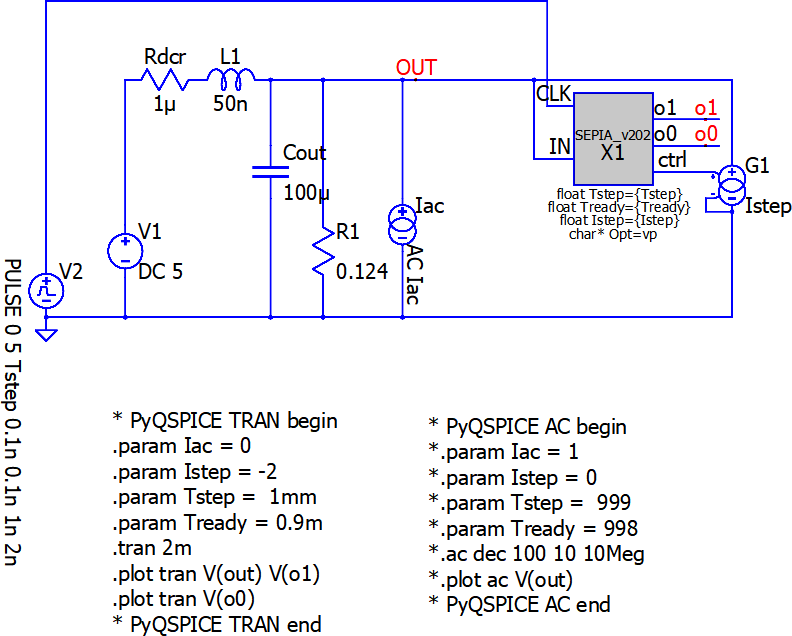

In [1]:
from PIL import Image
Image.open("Zo_SEPIA1.sch.png")

In this model, we know the Quality factor from this simple equation.

$$
Q = \frac{R_{1}}{\sqrt{\frac{L1}{C_{OUT}}}}
$$

From the component values in the schematic, we have Q = 5.59.

In [2]:
from PyQSPICE import clsQSPICE as pqs

import re
import subprocess
import math
import cmath

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.transforms import ScaledTranslation as stran

import numpy as np
from numpy import sin, cos, pi, linspace

fname = "Zo_SEPIA1"
run = pqs(fname)
run.qsch2cir()
run.cir4label('ac')
run.cir4label('tran')

## 2. AC Simulation: Reference Data

First, we run an AC simulation for our reference data.

From the Q(Tg) plot, we can confirm that this circuit shows Q = 5.5.

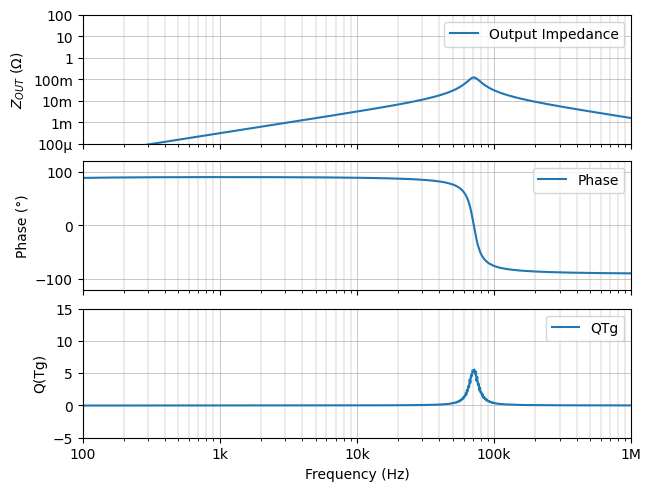

In [3]:
Ndata = 1024 * 2
run.selectSimLabel('ac', Nline = Ndata)

run.cir2qraw()

v = "V(out)"
i = "I(Iac)"

dfAC = run.LoadQRAW([v])

dfAC = run.GainPhase(dfAC, v, "abs(Zoac)", "arg(Zoac)")
run.comp2real(dfAC, ["Step", "abs(Zoac)", "arg(Zoac)", run.sim['Xlbl']])
#print(dfAC)

dfQ = pd.DataFrame()
dfQ = run.QTg(dfAC.loc[:,["Freq","arg(Zoac)"]], "fQTg", "QTg", 180/pi)
#print(dfQ)

plt.close('all')

fig, (axT, axM, axB) = plt.subplots(3, 1, sharex=True, constrained_layout=True)

dfAC.plot(ax=axT, x="Freq", y="abs(Zoac)", label="Output Impedance")
dfAC.plot(ax=axM, x="Freq", y="arg(Zoac)", label="Phase")
dfQ.plot(ax=axB, x="fQTg", y="QTg")
run.PrepFreqImpePlot(axT, "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-80,40], "")
run.PrepFreqGainPlot(axM, "Frequency (Hz)", r"Phase (°)", [100,1e6], [-120,120], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Q(Tg)", [100,1e6], [-5,15], "")

plt.savefig("Zo_SEPIA1.ac.png", format='png', bbox_inches='tight')

plt.show()

## 3. Transient Simulation: Step-Load

Now, we run a transient simulation with the SEPIA C++ Block driven step current load.

As we have Q = 5.5, we can see heavy ringing.

As a result of this simulation run with the SEPIA C++ block, it outputs the result of model fitting (which is expected to be identical to the original simulation).

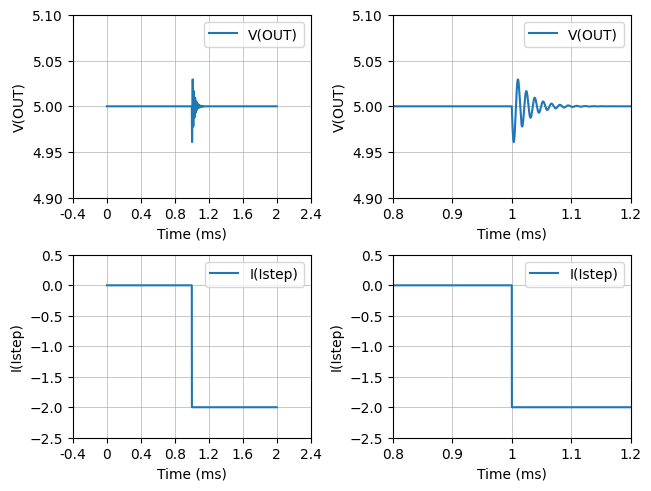

In [4]:
Ndata = 1024 * 16
run.selectSimLabel('tran', Nline = Ndata, Nbit = 80)

sepiaTran = "_sepia_tran"
sepiaAC   = "_sepia_ac"
sepiaLog  = "_sepia_log"
run.opt4SEPIA(run.path['tran.cir'], prnPeak = True, Verbose = True,
              fnTran1 = sepiaTran, runTran1 = False, fnAC1 = sepiaAC, runAC1 = False, fnLog = sepiaLog)
    
run.cir2qraw()
#run.copy2qraw()  #use this line to re-use existing QRAW file

v = "V(out)"
o = "V(o1)"
i = "I(G1)"

dfTRAN = run.LoadQRAW([v,i,o])
#print(dfTRAN)

plt.close('all')

fig, ax = plt.subplots(2, 2, constrained_layout=True)

for n in [0, 1]:
    dfTRAN.plot(ax=ax[0,n], x="Time", y=v, label="V(OUT)")
    dfTRAN.plot(ax=ax[1,n], x="Time", y=i, label="I(Istep)")

run.PrepTimePlot(ax[0,0], "Time", r"V(OUT)", "auto", [4.9,5.1], "")
run.PrepTimePlot(ax[1,0], "Time", r"I(Istep)", "auto", [-2.5,0.5], "")
run.PrepTimePlot(ax[0,1], "Time", r"V(OUT)",   [0.8e-3,1.2e-3], [4.9,5.1], "")
run.PrepTimePlot(ax[1,1], "Time", r"I(Istep)", [0.8e-3,1.2e-3], [-2.5,0.5], "")

plt.savefig("Zo_SEPIA1.tran.png", format='png', bbox_inches='tight')

plt.show()

Generating a plot illustrating ringing peaks.

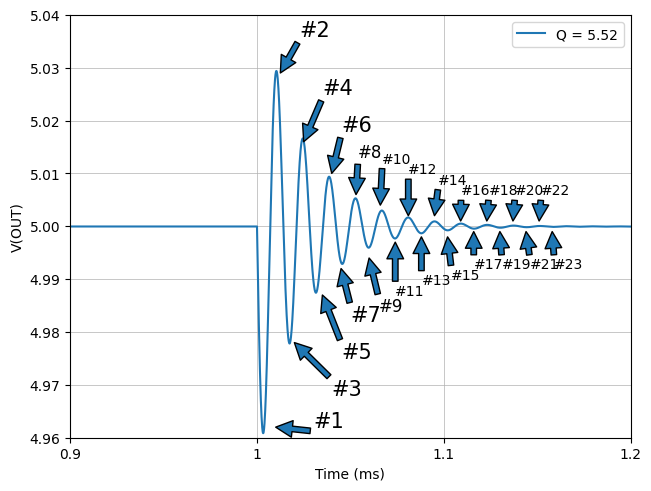

In [5]:
plt.close('all')

fig, ax = plt.subplots(1, 1, constrained_layout=True)
dfTRAN.plot(ax=ax, x="Time", y=v, label="Q = 5.52")
run.PrepTimePlot(ax, "Time", r"V(OUT)",   [0.9e-3,1.2e-3], [4.96,5.04], "")

ax.annotate("#1", xy=(1.01e-3,4.962), size=15, xytext=(1.03e-3, 4.962), color="black", arrowprops=dict())
ax.annotate("#2", xy=(1.0125e-3,5.029), size=15, xytext=(1.0225e-3, 5.036), color="black", arrowprops=dict())
ax.annotate("#3", xy=(1.02e-3,4.978), size=15, xytext=(1.04e-3, 4.968), color="black", arrowprops=dict())
ax.annotate("#4", xy=(1.025e-3,5.016), size=15, xytext=(1.035e-3, 5.025), color="black", arrowprops=dict())
ax.annotate("#5", xy=(1.035e-3,4.987), size=15, xytext=(1.045e-3, 4.975), color="black", arrowprops=dict())
ax.annotate("#6", xy=(1.04e-3,5.01), size=15, xytext=(1.045e-3, 5.018), color="black", arrowprops=dict())
ax.annotate("#7", xy=(1.045e-3,4.992), size=15, xytext=(1.05e-3, 4.982), color="black", arrowprops=dict())
ax.annotate("#8", xy=(1.053e-3,5.006), size=12, xytext=(1.054e-3, 5.013), color="black", arrowprops=dict())
ax.annotate("#9", xy=(1.06e-3,4.994), size=12, xytext=(1.065e-3, 4.984), color="black", arrowprops=dict())
ax.annotate("#10", xy=(1.066e-3,5.004), size=10, xytext=(1.067e-3, 5.012), color="black", arrowprops=dict())
ax.annotate("#11", xy=(1.074e-3,4.997), size=10, xytext=(1.074e-3, 4.987), color="black", arrowprops=dict())
ax.annotate("#12", xy=(1.081e-3,5.002), size=10, xytext=(1.081e-3, 5.01), color="black", arrowprops=dict())
ax.annotate("#13", xy=(1.088e-3,4.998), size=10, xytext=(1.088e-3, 4.989), color="black", arrowprops=dict())
ax.annotate("#14", xy=(1.095e-3,5.002), size=10, xytext=(1.097e-3, 5.008), color="black", arrowprops=dict())
ax.annotate("#15", xy=(1.102e-3,4.998), size=10, xytext=(1.104e-3, 4.99), color="black", arrowprops=dict())
ax.annotate("#16", xy=(1.109e-3,5.001), size=10, xytext=(1.1092e-3, 5.006), color="black", arrowprops=dict())
ax.annotate("#17", xy=(1.116e-3,4.999), size=10, xytext=(1.116e-3, 4.992), color="black", arrowprops=dict())
ax.annotate("#18", xy=(1.123e-3,5.001), size=10, xytext=(1.124e-3, 5.006), color="black", arrowprops=dict())
ax.annotate("#19", xy=(1.13e-3,4.999), size=10, xytext=(1.131e-3, 4.992), color="black", arrowprops=dict())
ax.annotate("#20", xy=(1.137e-3,5.001), size=10, xytext=(1.138e-3, 5.006), color="black", arrowprops=dict())
ax.annotate("#21", xy=(1.144e-3,4.999), size=10, xytext=(1.146e-3, 4.992), color="black", arrowprops=dict())
ax.annotate("#22", xy=(1.151e-3,5.001), size=10, xytext=(1.152e-3, 5.006), color="black", arrowprops=dict())
ax.annotate("#23", xy=(1.158e-3,4.999), size=10, xytext=(1.159e-3, 4.992), color="black", arrowprops=dict())

plt.savefig("Zo_Qring.png", format='png', bbox_inches='tight')

plt.show()

Showing SEPIA@QSPICE block peak-detection.

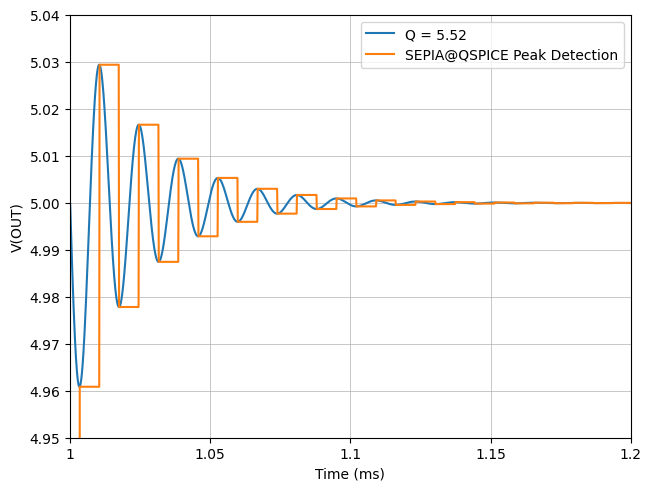

In [6]:
plt.close('all')

fig, ax = plt.subplots(1, 1, constrained_layout=True)
dfTRAN.plot(ax=ax, x="Time", y=v, label="Q = 5.52")
dfTRAN.plot(ax=ax, x="Time", y=o, label="SEPIA@QSPICE Peak Detection")
run.PrepTimePlot(ax, "Time", r"V(OUT)",   [1e-3,1.2e-3], [4.95,5.04], "")

plt.savefig("Zo_soq.png", format='png', bbox_inches='tight')

plt.show()

## 4. Transient Result from SEPIA Model-Fitting

### 4.1  Before running a simulation on the SEPIA output

Because of this Sim 1 setup, regenerating itself, it's obvious that SEPIA did a good job When we review the SEPIA output of its model-fitting.

In [7]:
run2 = pqs(sepiaTran)

with open(run2.path['cir'], encoding='SJIS') as f: print(f.read())
with open(sepiaLog + ".log") as f: print(f.read())

* This file is generated by the SEPIA on QSPICE v202.
Vbias N03 0   4.99995968e+00
Rdcr N03 N02   1.01254880e-06
Lout N02 SEPIA_MODEL_FITTING   5.02044019e-08
Cout 0 SEPIA_MODEL_FITTING   9.87820584e-05

Rdump 0 SEPIA_MODEL_FITTING   1.24456538e-01
Istep 0 SEPIA_MODEL_FITTING pwl 0 0   1.00000000e-03 0   1.00000100e-03  -2.00000000e+00
.TRAN 0   2.00000000e-03 0 10n
.PLOT TRAN V(SEPIA_MODEL_FITTING)


SEPIA: Tready=  0.000900, Tstep=  0.001000, Istep= -2.000000, Option:pvl_sepia_log:t1_sepia_tran:a1_sepia_ac:x
SEPIA: fTran1=_sepia_tran (Auto-Sim: OFF)
SEPIA: fAC1=_sepia_ac (Auto-Sim: OFF)
SEPIA: log=_sepia_log


========  SEPIA Result Begin  ========
SEPIA: Q= 5.52, Icoil/2=2.66e-15, f=70.89(kHz), T=14.11(us), PM=10.35(deg),
SEPIA: Z=2.25e-02, L=5.02e-08, C=9.88e-05, 
SEPIA: (sL+Rcoil) // ((1/sC)+Rcap) Modeling
  Rcoil+Rcap=4.08e-03,  Rcoil=1.01e-06,   Rcap=4.08e-03, 
SEPIA: (sL) // (1/sC) // Rdump Modeling
  Rdump=1.24e-01,  Rcoil=1.01e-06, 
SEPIA: preAve=5.00e+00, postAve=5.00e+00
==

### 4.2  Simulation on SEPIA Output


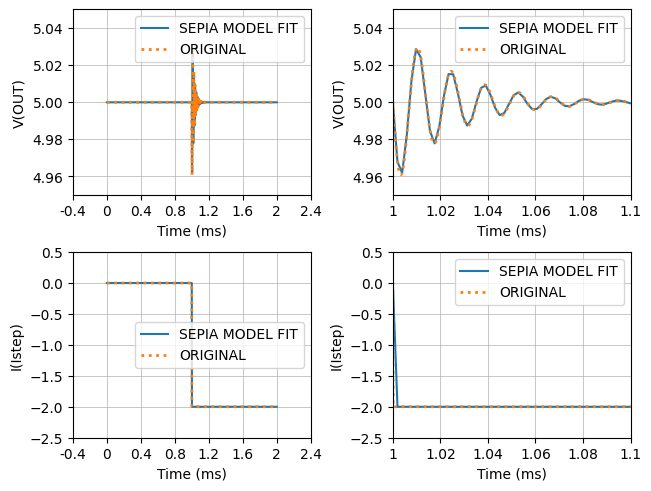

In [8]:
Ndata = 1024
run2.setNline(Ndata)
run2.setNbit(80)
run2.cir2qraw()
#run.copy2qraw()  #use this line to re-use existing QRAW file

v2 = "V(SEPIA_MODEL_FITTING)"
i2 = "I(Istep)"

dfTRAN2 = run2.LoadQRAW([v2,i2])
#print(dfTRAN2)

plt.close('all')

fig, ax = plt.subplots(2, 2, constrained_layout=True)

for n in [0, 1]:
    dfTRAN2.plot(ax=ax[0,n], x="Time", y=v2, label="SEPIA MODEL FIT")
    dfTRAN2.plot(ax=ax[1,n], x="Time", y=i2, label="SEPIA MODEL FIT")
    dfTRAN.plot(ax=ax[0,n], x="Time", y=v, label="ORIGINAL", linestyle="dotted", linewidth=2)
    dfTRAN.plot(ax=ax[1,n], x="Time", y=i, label="ORIGINAL", linestyle="dotted", linewidth=2)


run2.PrepTimePlot(ax[0,0], "Time", r"V(OUT)", "auto", [4.95,5.05], "")
run2.PrepTimePlot(ax[1,0], "Time", r"I(Istep)", "auto", [-2.5,0.5], "")
run2.PrepTimePlot(ax[0,1], "Time", r"V(OUT)",   [1e-3,1.1e-3], [4.95,5.05], "")
run2.PrepTimePlot(ax[1,1], "Time", r"I(Istep)", [1e-3,1.1e-3], [-2.5,0.5], "")

plt.savefig("SEPIA_OUT1.tran.png", format='png', bbox_inches='tight')

plt.show()

### 4.3  AC Simulation on SEPIA Output, Comparison


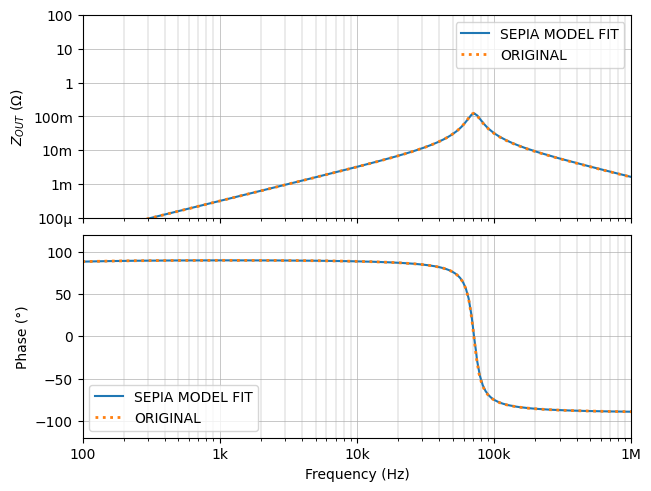

In [9]:
run3 = pqs(sepiaAC)

Ndata = 1024
run3.setNline(Ndata)
run3.setNbit(80)
run3.cir2qraw()

v3 = "V(SEPIA_MODEL_FITTING)"
i3 = "I(Iac)"

dfAC2 = run3.LoadQRAW([v3,i3])

dfAC2 = run.GainPhase(dfAC2, v3, "abs(Zoac)", "arg(Zoac)")
run.comp2real(dfAC2, ["Step", "abs(Zoac)", "arg(Zoac)", run3.sim['Xlbl']])

plt.close('all')

fig, (axT, axB) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

dfAC2.plot(ax=axT, x="Freq", y="abs(Zoac)", label="SEPIA MODEL FIT")
dfAC2.plot(ax=axB, x="Freq", y="arg(Zoac)", label="SEPIA MODEL FIT")

dfAC.plot(ax=axT, x="Freq", y="abs(Zoac)", label="ORIGINAL", linestyle="dotted", linewidth=2)
dfAC.plot(ax=axB, x="Freq", y="arg(Zoac)", label="ORIGINAL", linestyle="dotted", linewidth=2)

run.PrepFreqImpePlot(axT, "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-80,40], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Phase (°)", [100,1e6], [-120,120], "")

plt.savefig("SEPIA_OUT1.ac.png", format='png', bbox_inches='tight')

plt.show()

## 5. Notes on Model Fitting #1

The SEPIA routine can extract C and L value pair precisely, then, we need to pay attention how we place dumping resistors $R_{DUMP}$ which determines the Q.  In this model, we want an R-L-C parallel resonant model BUT we need to have the $R_{DCR}$ so to represent the load-regulation, the difference between pre-step voltage and post-step voltage, the program find $R_{DCR} = (V_{Post-STEP} - V_{Pre-STEP}) / I_{STEP}$.

With proper approximations, we get Q of this model as shown at the top of this note, but apparently we don't have $R_{DCR}$ here.

$$
Q = \frac{R_{1}}{\sqrt{\frac{L1}{C_{OUT}}}}
$$

That means, this approximation is valid when $R_{DCR}$ is small enough, which is the case when applying this SEPIA model #1 to a VRM.

With high $R_{DCR}$ situations, we use model #0 ([**"Sim1"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article11/Sim1)).

## 6. Cleaning

Removing 1GB data file.

In [10]:
run.clean(['tran.qraw','ac.qraw'])
run2.clean(['qraw'])
run3.clean(['qraw'])